In [1]:
import xarray as xr
import cfgrib
import numpy as np
import matplotlib.pyplot as plt

from data_processor import DataProcessor
from regressor import Regressor

/home/kamil/Desktop/git/meteoapp-data/venv/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [2]:
# https://github.com/ecmwf/cfgrib/issues/164
grib_data = cfgrib.open_datasets('../data.grib')
surface = grib_data[0] 
hybrid = grib_data[1] 

In [3]:
feature_list = ['t2m', 'sp', 'tcc', 'u10', 'v10', 'tp', 'sf']
t2m = surface.t2m.to_numpy() - 273.15  # -> C
sp = surface.sp.to_numpy() / 100       # -> hPa
tcc = surface.tcc.to_numpy()
u10 = surface.u10.to_numpy()
v10 = surface.v10.to_numpy()
tp = hybrid.tp.to_numpy().reshape((-1,) + hybrid.tp.shape[2:])
sf = hybrid.sf.to_numpy().reshape((-1,) + hybrid.sf.shape[2:])
data = np.stack((t2m, sp, tcc, u10, v10, tp, sf), axis=-1)

In [4]:
# s -> AUTOREG_SEQUENCE_LENGTH (input_size)
# fh -> FORECASTING_HORIZON
# (X1,X2,...,Xs) -> (Ys+1,Ys+2,...,Ys+fh)
s = 5
fh = 2

processor = DataProcessor(data)
X, y = processor.preprocess(s, fh)
X_train, X_test, y_train, y_test = processor.train_test_split(X, y)

In [5]:
X.shape, y.shape

((226, 5, 25, 45, 7), (226, 2, 25, 45, 7))

(46, 2, 25, 45, 7) (46, 2, 25, 45, 7)
RMSE t2m: 7.52; R2 t2m: -1.971
RMSE sp: 996.495; R2 sp: -2686.43
RMSE tcc: 0.799; R2 tcc: -8.039
RMSE u10: 3.725; R2 u10: -1.03
RMSE v10: 0.838; R2 v10: -0.53
RMSE tp: 0.0; R2 tp: -0.113
RMSE sf: 0.0; R2 sf: 0.0


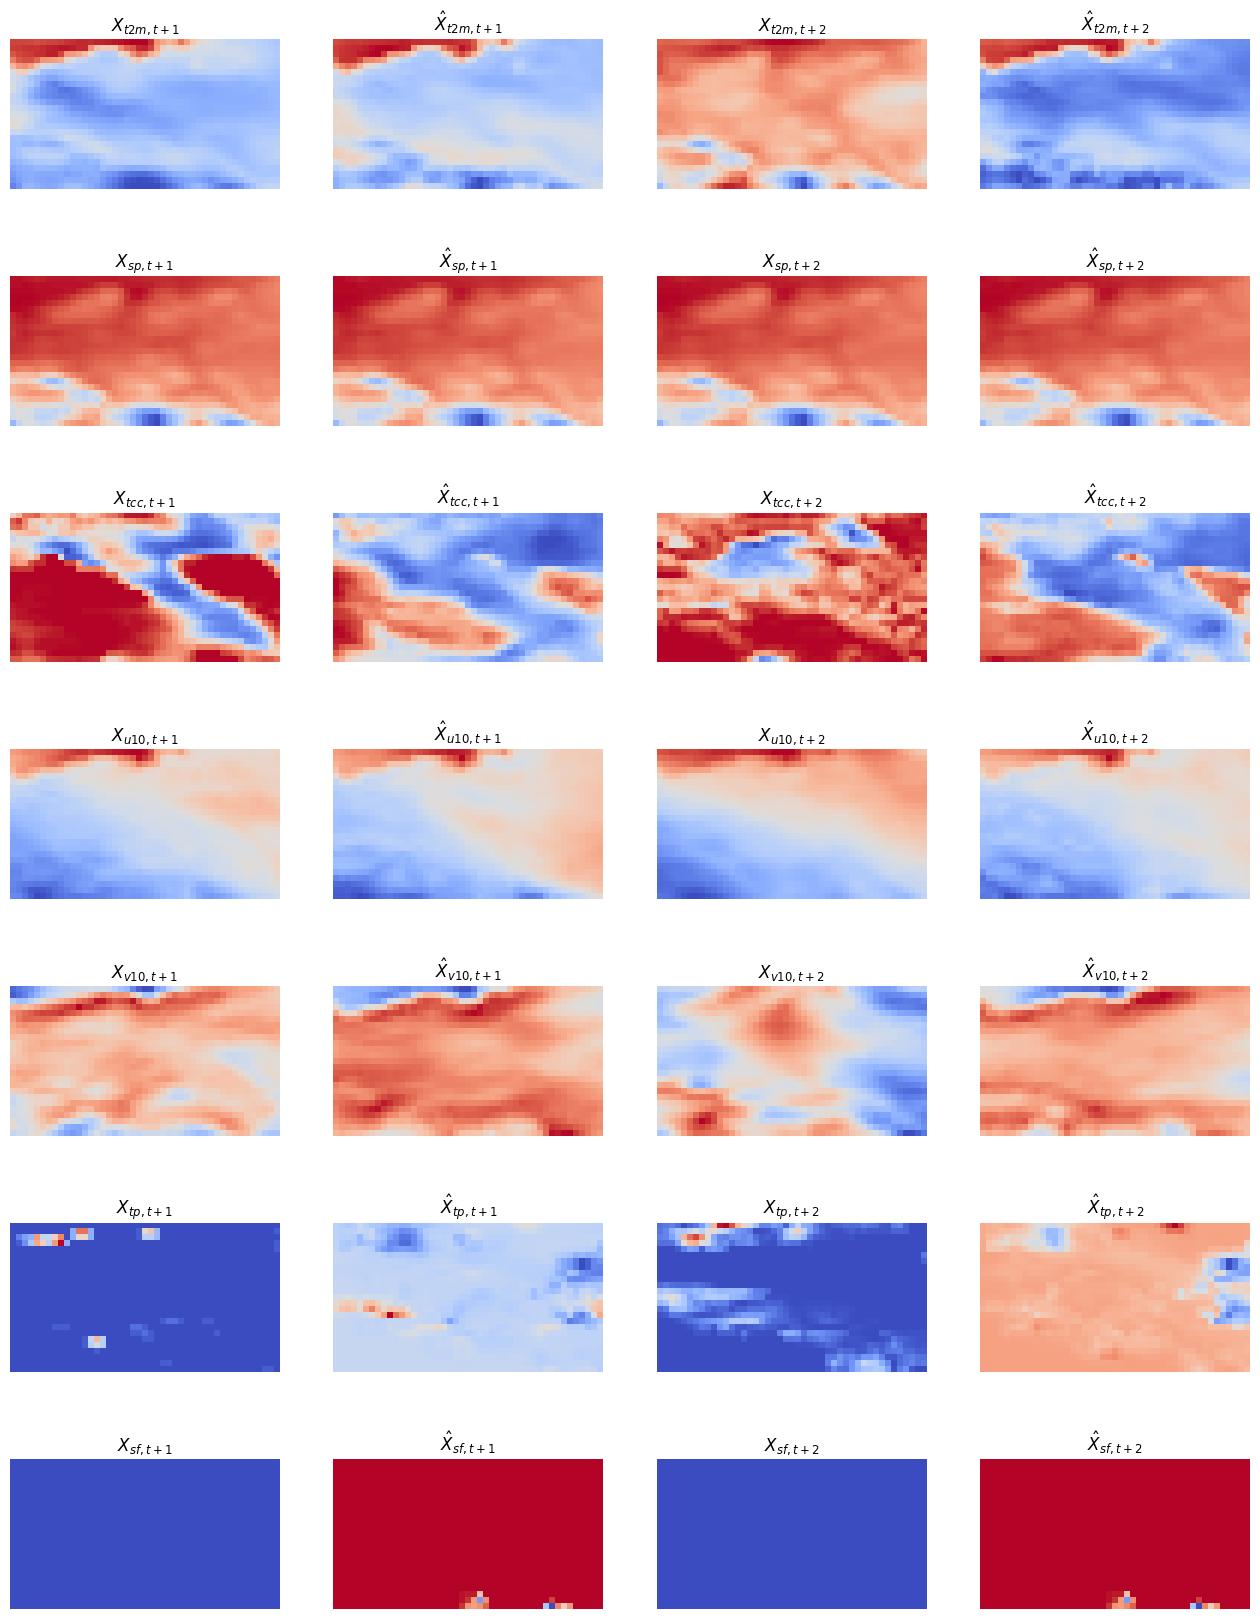

RMSE t2m: 8.333; R2 t2m: -8.001
RMSE sp: 995.621; R2 sp: -2689.001
RMSE tcc: 0.758; R2 tcc: -8.325
RMSE u10: 3.842; R2 u10: -0.666
RMSE v10: 1.013; R2 v10: -0.547
RMSE tp: 0.0; R2 tp: -0.111
RMSE sf: 0.0; R2 sf: 0.0


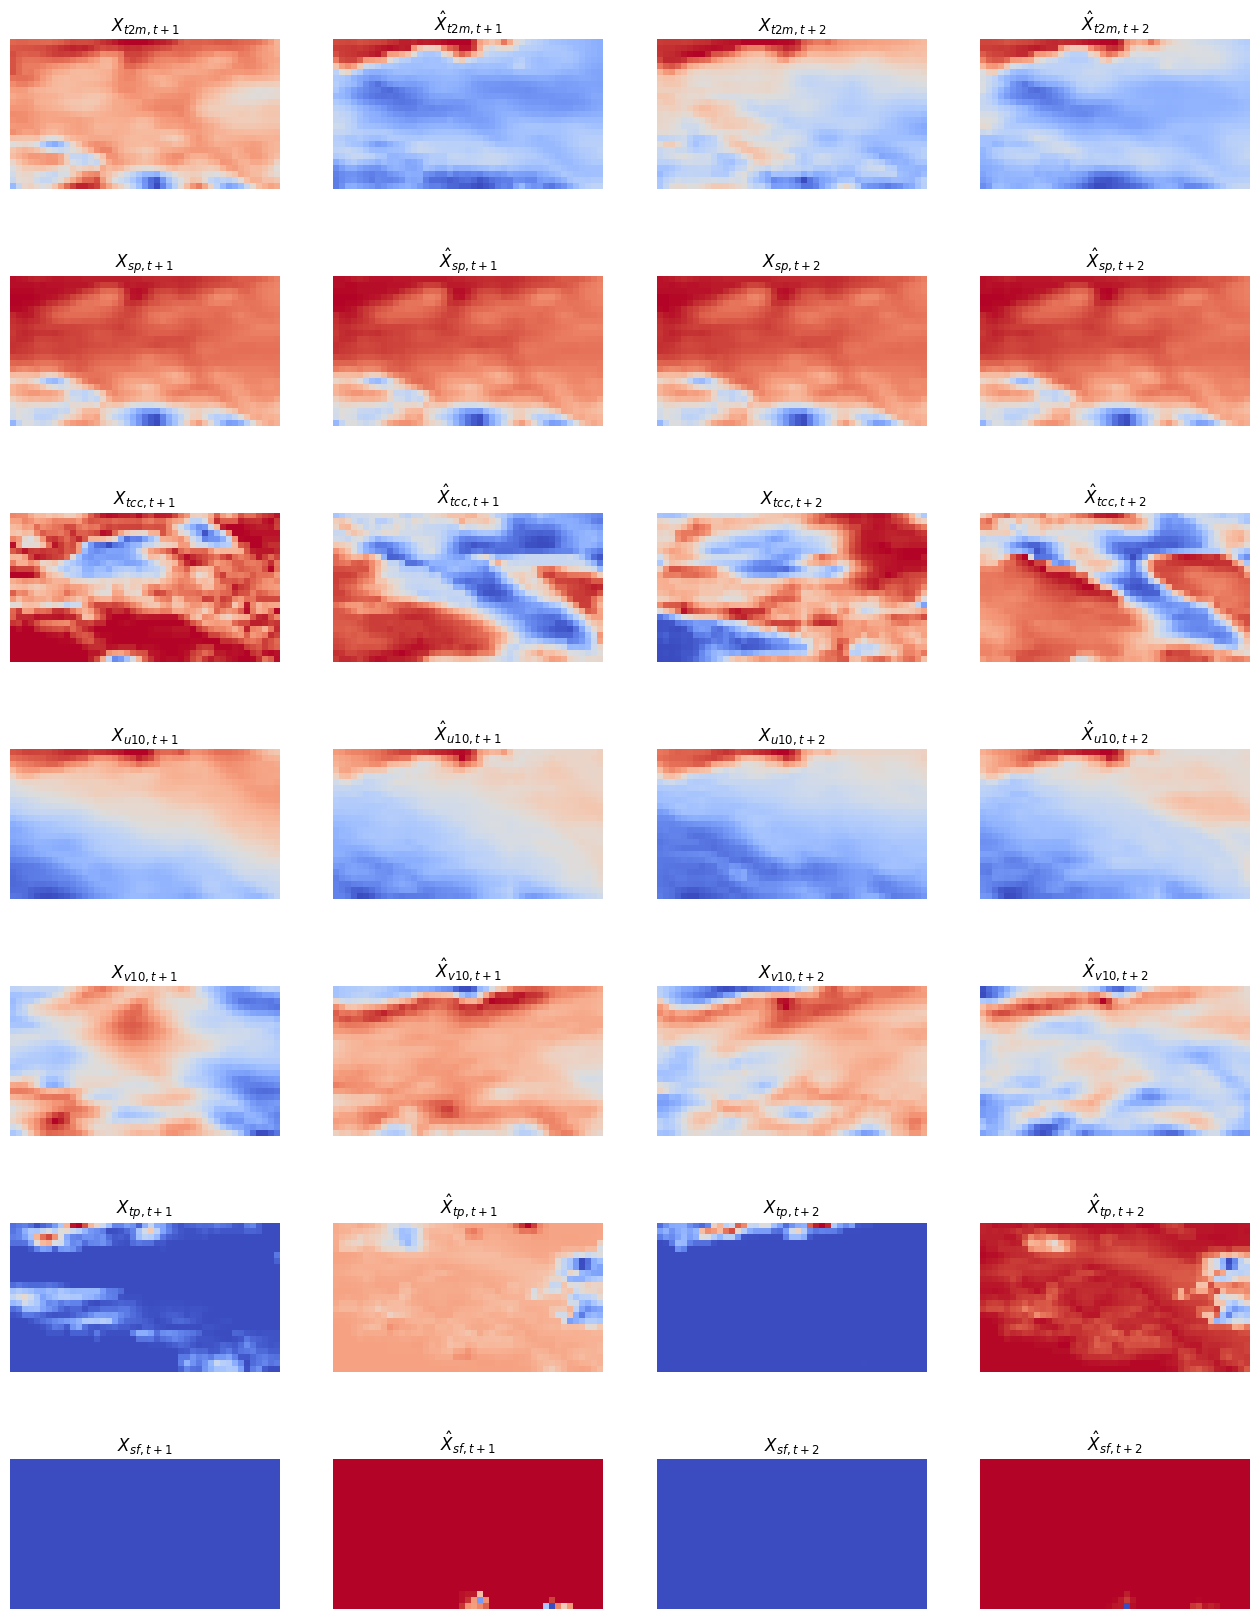

RMSE t2m: 5.251; R2 t2m: -1.885
RMSE sp: 994.38; R2 sp: -2744.859
RMSE tcc: 0.653; R2 tcc: -3.797
RMSE u10: 3.665; R2 u10: -0.551
RMSE v10: 1.509; R2 v10: -1.326
RMSE tp: 0.0; R2 tp: -0.059
RMSE sf: 0.0; R2 sf: 0.0


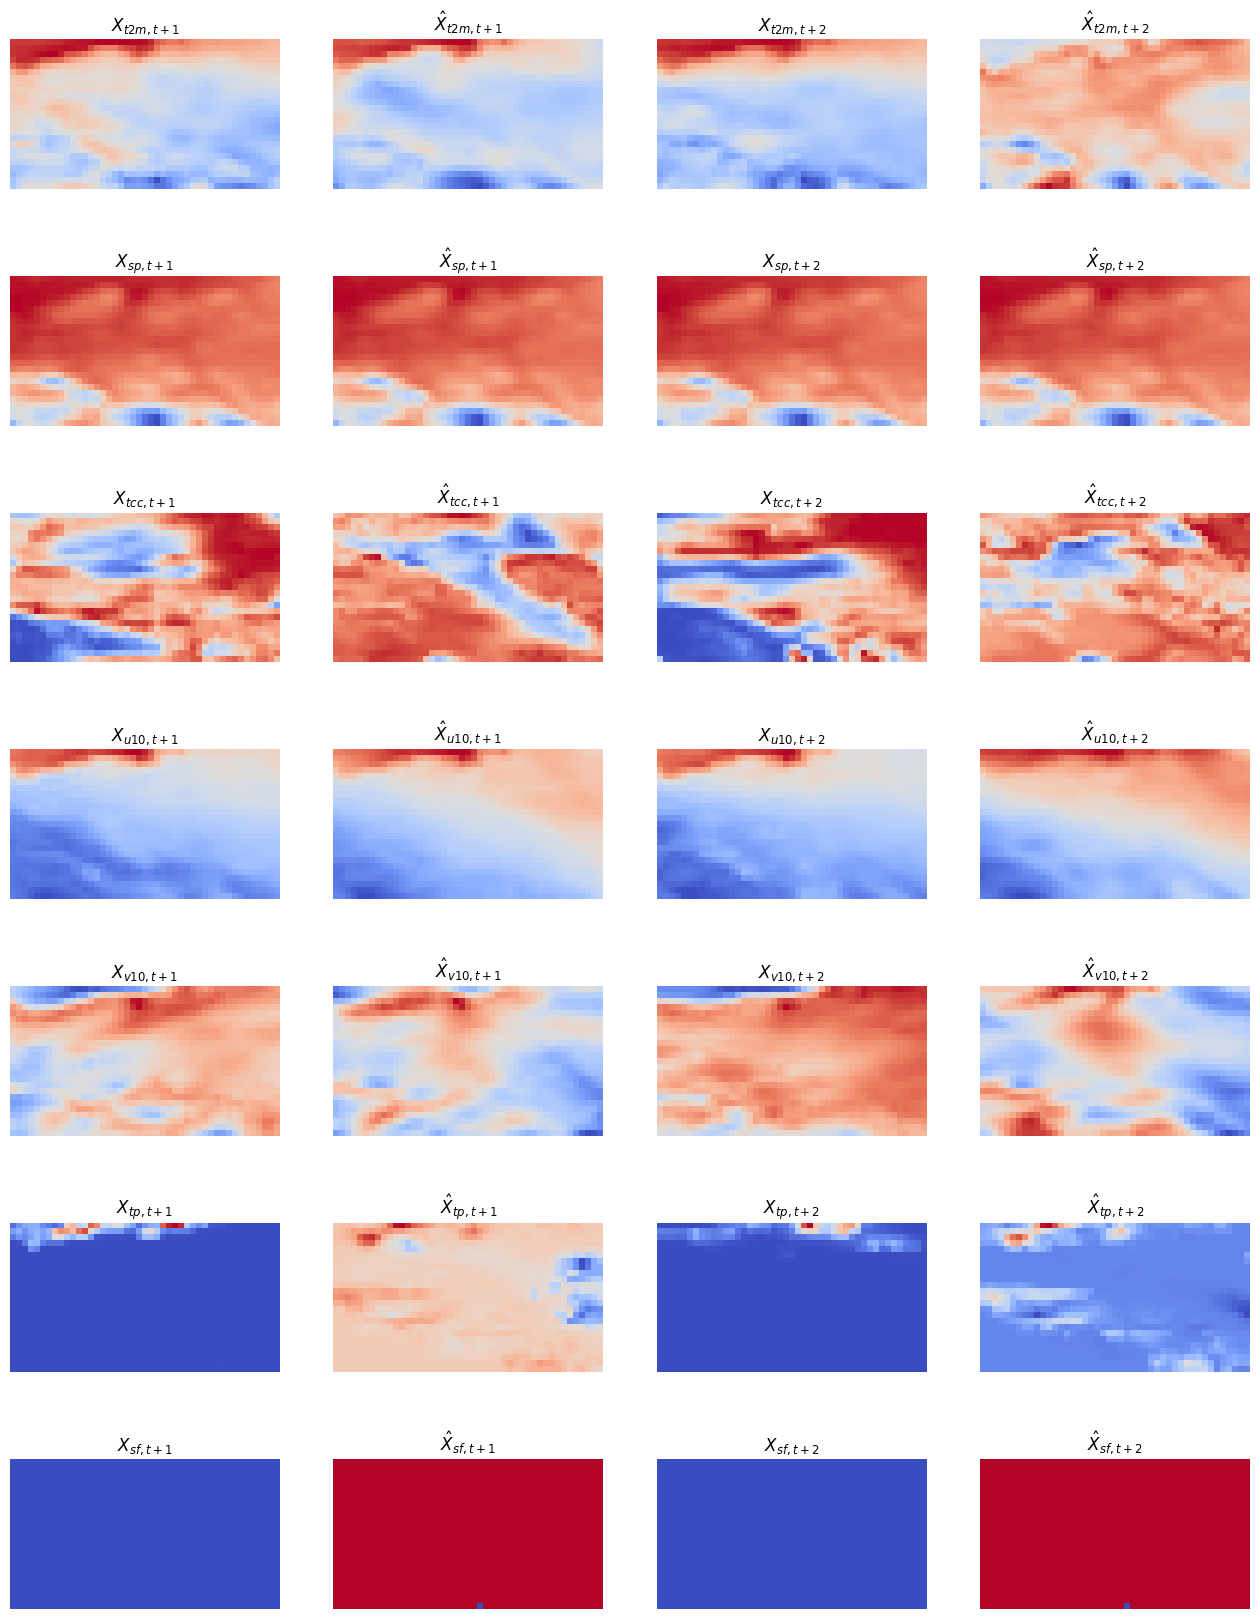

RMSE t2m: 4.307; R2 t2m: -0.674
RMSE sp: 992.889; R2 sp: -2807.835
RMSE tcc: 0.661; R2 tcc: -3.047
RMSE u10: 3.893; R2 u10: -0.77
RMSE v10: 1.795; R2 v10: -1.049
RMSE tp: 0.0; R2 tp: -0.075
RMSE sf: 0.0; R2 sf: 0.0


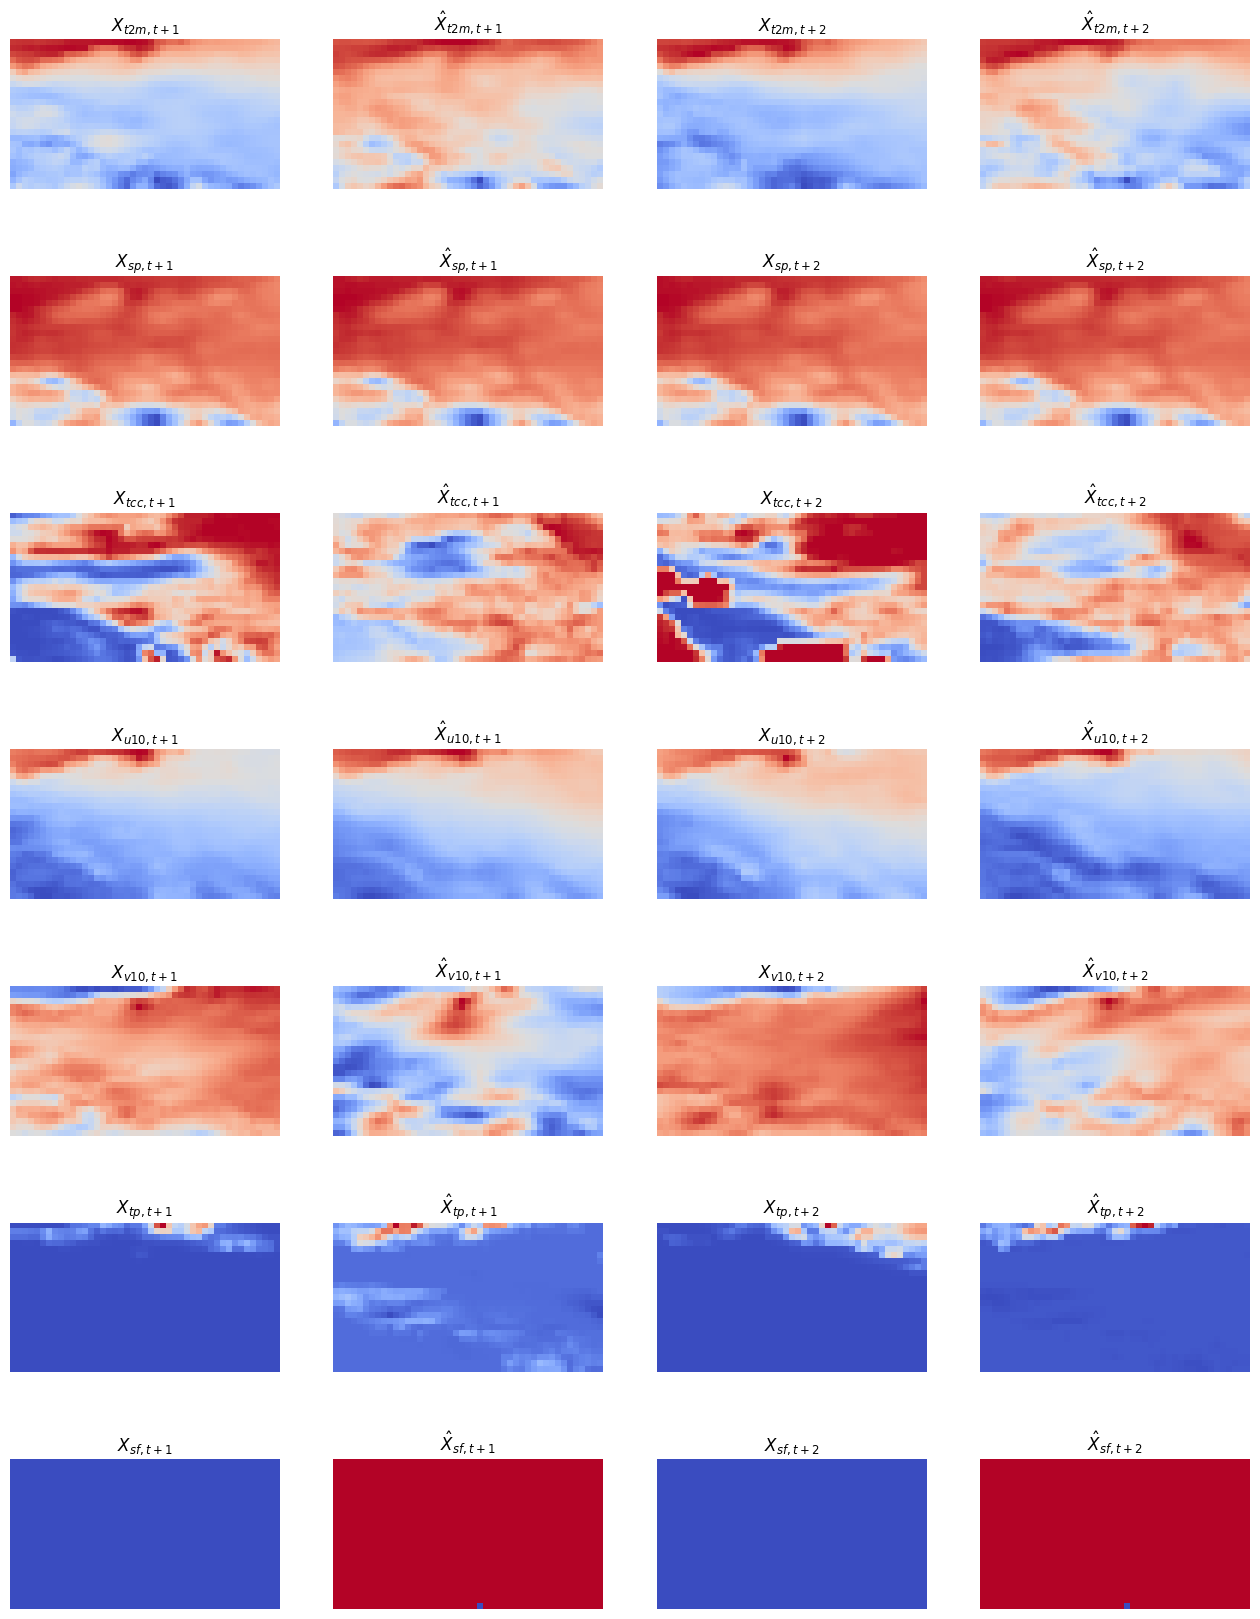

Evaluation metrics for entire test set:
RMSE t2m: 9.828858773957165; R2 t2m: -5745092.399902704
RMSE sp: 981.1047500150758; R2 sp: -13803420.705338638
RMSE tcc: 0.8937081918579823; R2 tcc: -8069172.084254399
RMSE u10: 3.7547300217642228; R2 u10: -1456120.5579100356
RMSE v10: 1.972567706936772; R2 v10: -1546501.7445413521
RMSE tp: 0.0005125870727286384; R2 tp: -1663876.3373903313
RMSE sf: 1.59106312078447e-06; R2 sf: -1696085.2088593268


In [6]:
reg = 'linear'
linearreg = Regressor(X.shape, fh, feature_list, regressor_type=reg)
linearreg.train(X_train, y_train)
y1,y2 = linearreg.predict_and_evaluate(X_test, y_test, max_samples=4)

(46, 2, 25, 45, 7) (46, 2, 25, 45, 7)
RMSE t2m: 7.52; R2 t2m: -1.971
RMSE sp: 996.495; R2 sp: -2686.43
RMSE tcc: 0.799; R2 tcc: -8.039
RMSE u10: 3.725; R2 u10: -1.03
RMSE v10: 0.838; R2 v10: -0.53
RMSE tp: 0.0; R2 tp: -0.113
RMSE sf: 0.0; R2 sf: 0.0


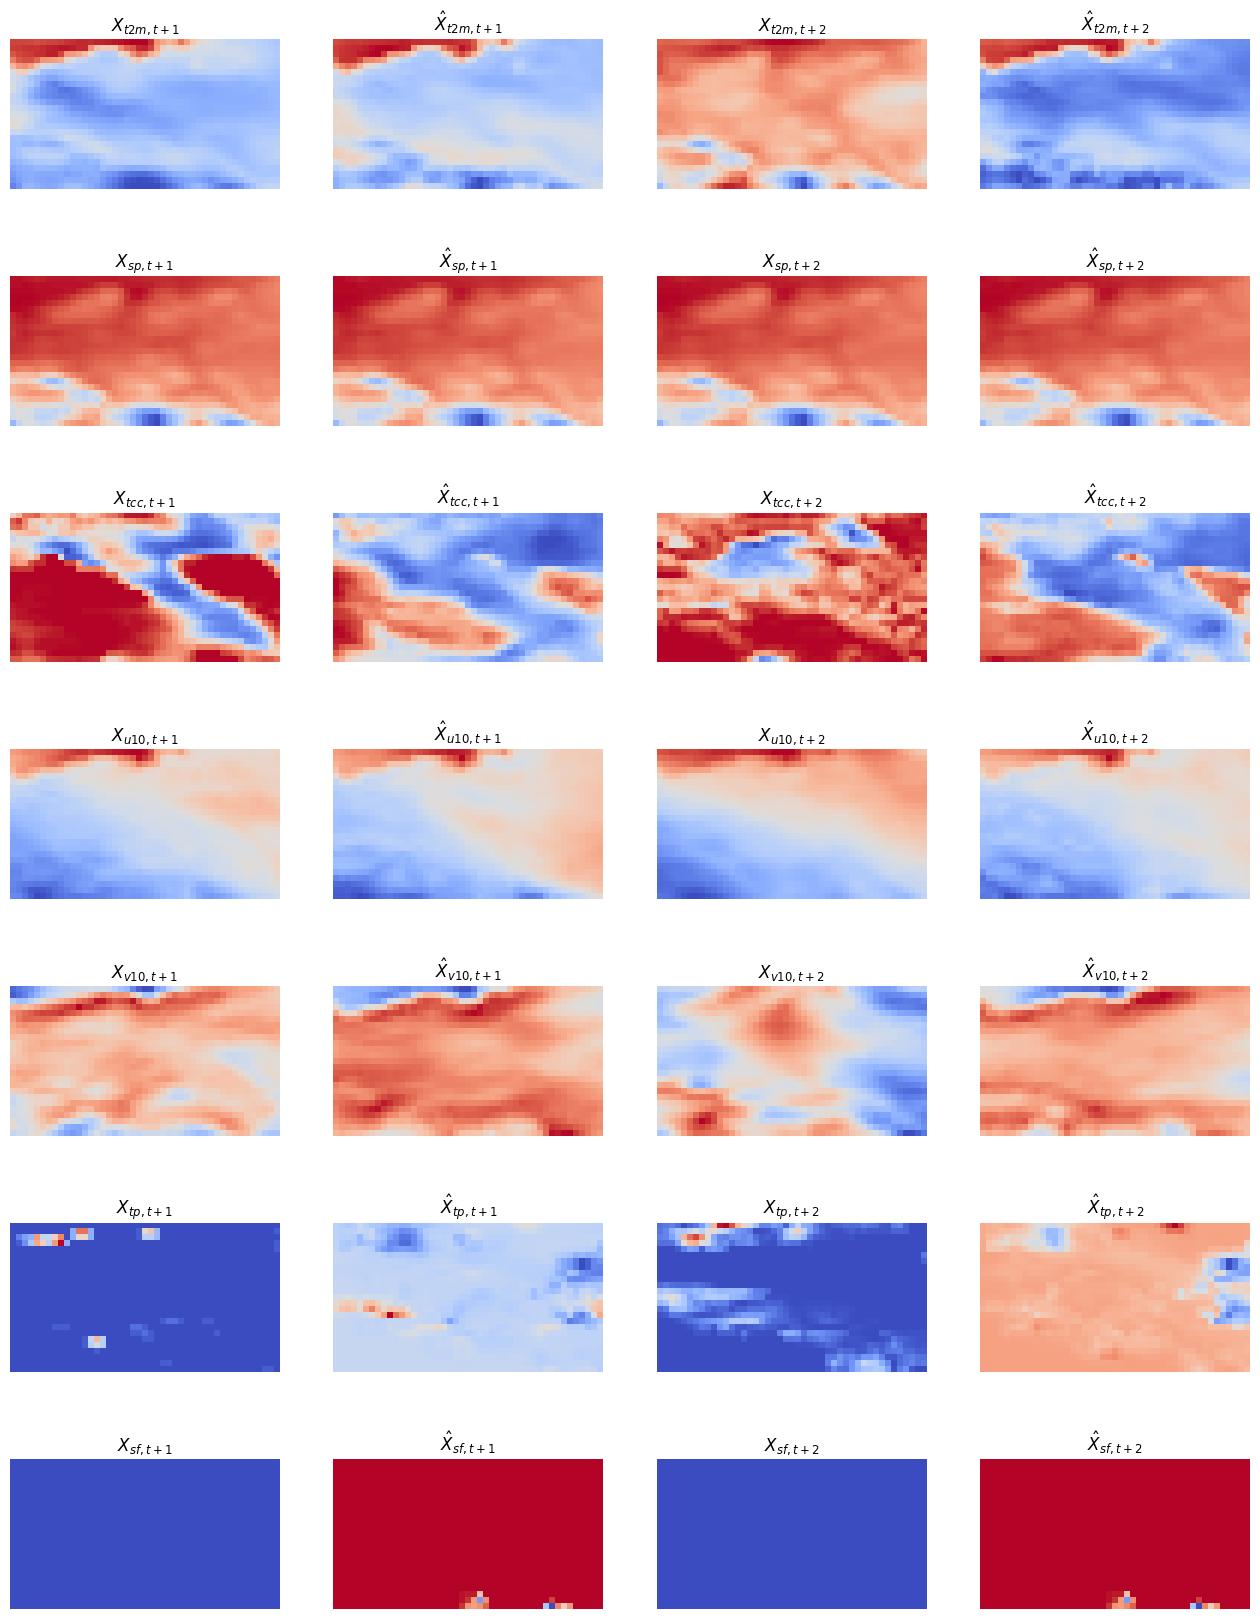

RMSE t2m: 8.333; R2 t2m: -8.001
RMSE sp: 995.621; R2 sp: -2689.001
RMSE tcc: 0.758; R2 tcc: -8.325
RMSE u10: 3.842; R2 u10: -0.666
RMSE v10: 1.013; R2 v10: -0.547
RMSE tp: 0.0; R2 tp: -0.111
RMSE sf: 0.0; R2 sf: 0.0


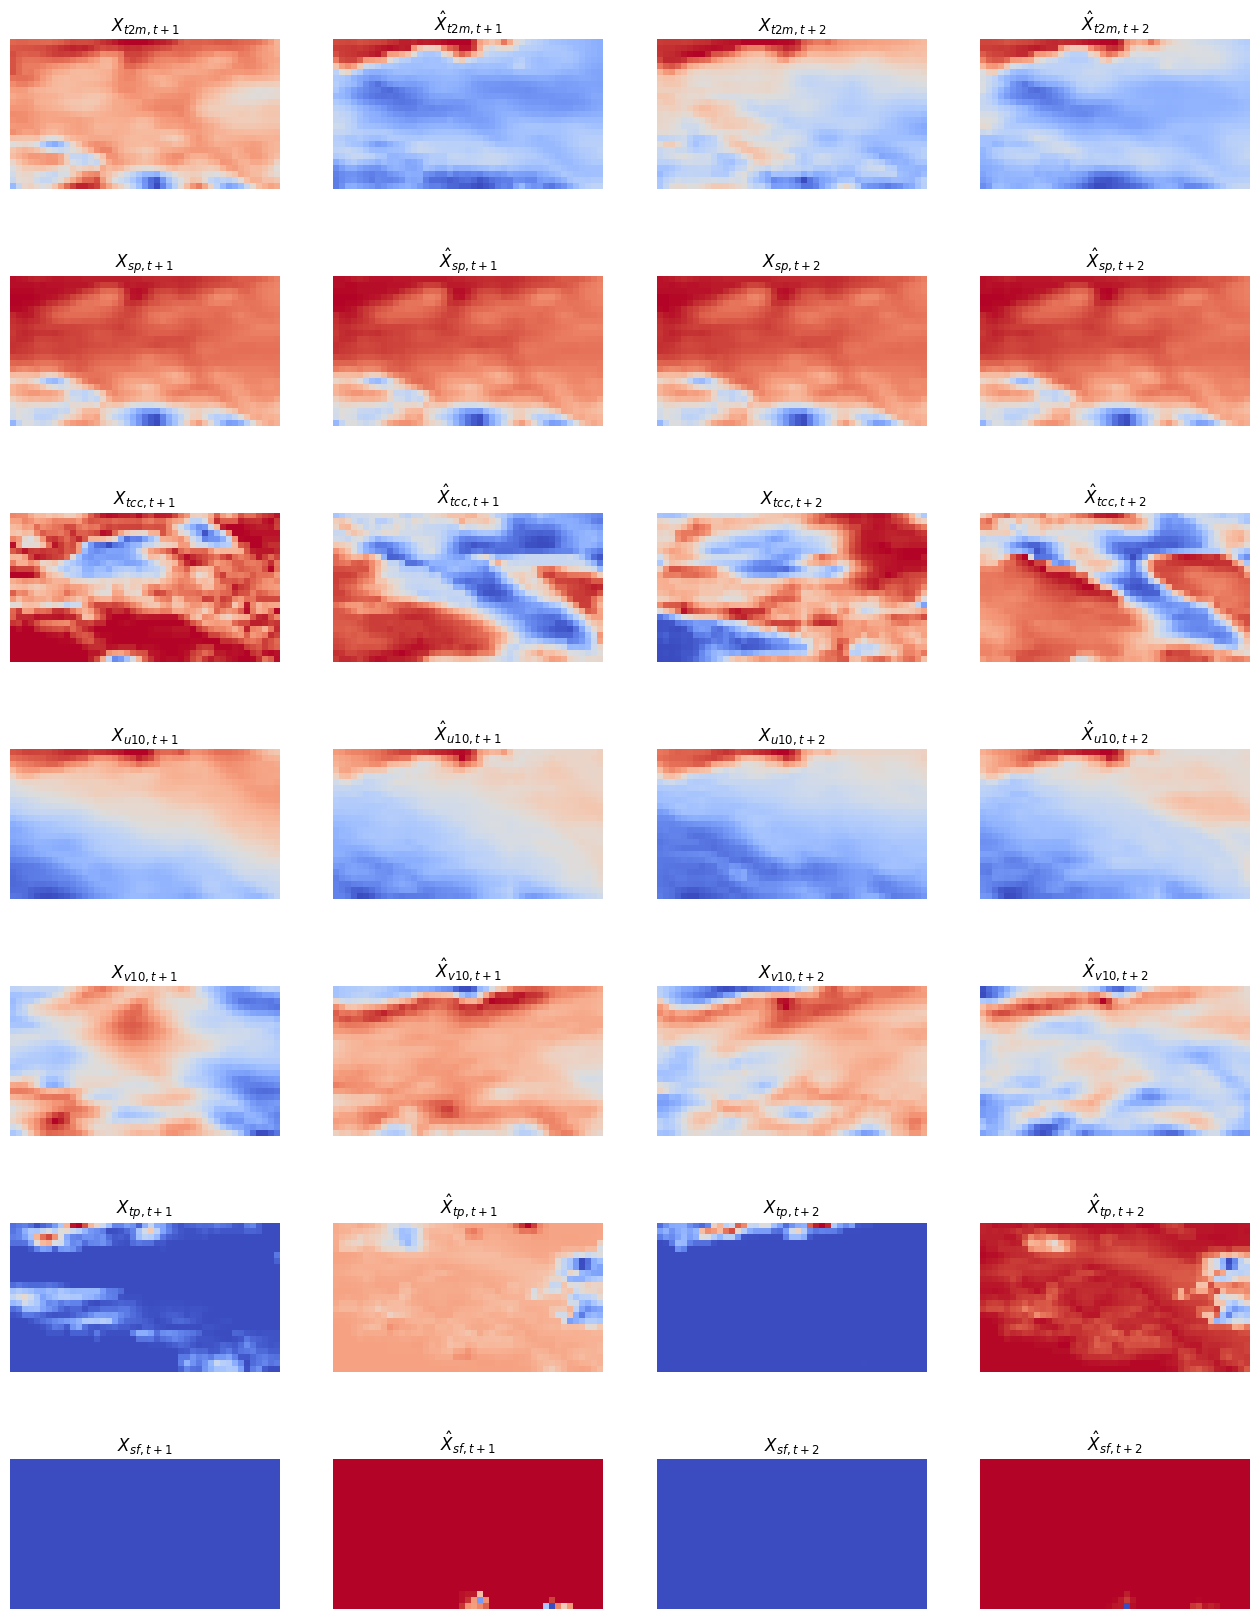

RMSE t2m: 5.251; R2 t2m: -1.885
RMSE sp: 994.38; R2 sp: -2744.859
RMSE tcc: 0.653; R2 tcc: -3.797
RMSE u10: 3.665; R2 u10: -0.551
RMSE v10: 1.509; R2 v10: -1.326
RMSE tp: 0.0; R2 tp: -0.059
RMSE sf: 0.0; R2 sf: 0.0


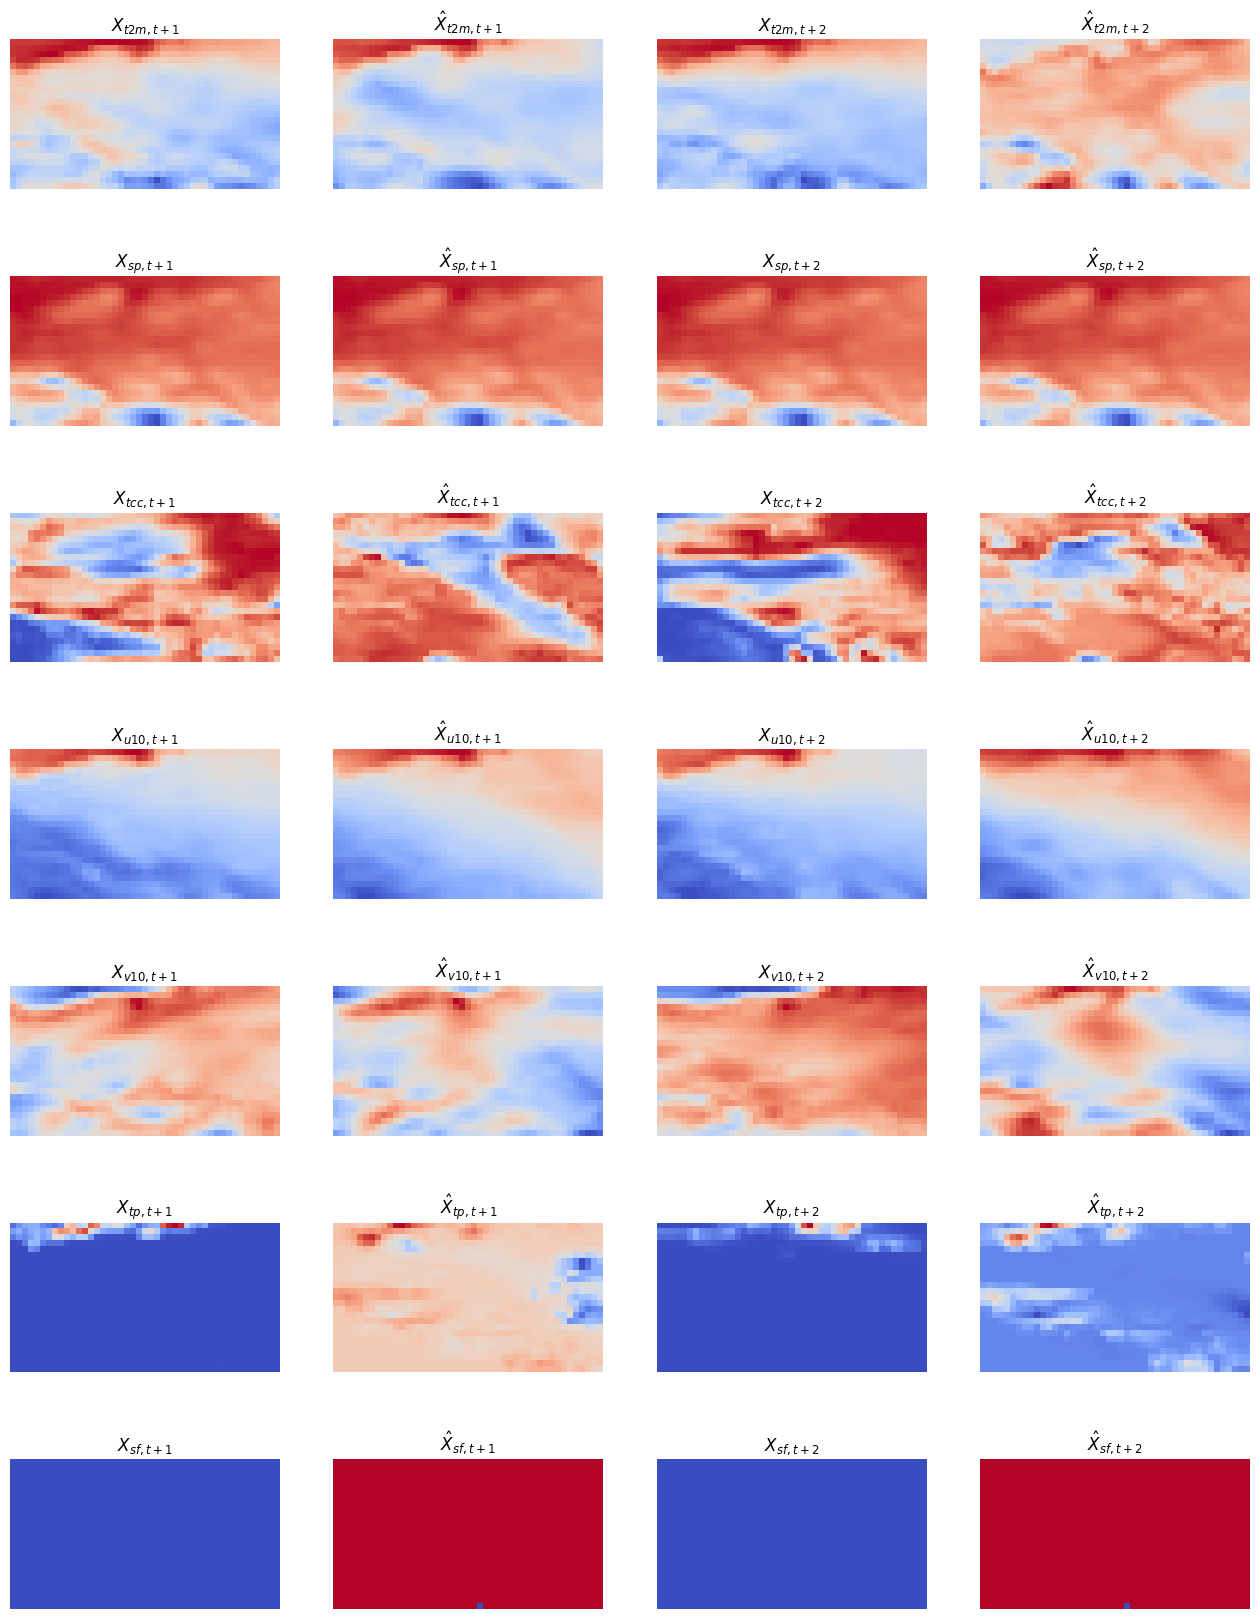

RMSE t2m: 4.307; R2 t2m: -0.674
RMSE sp: 992.889; R2 sp: -2807.835
RMSE tcc: 0.661; R2 tcc: -3.047
RMSE u10: 3.893; R2 u10: -0.77
RMSE v10: 1.795; R2 v10: -1.049
RMSE tp: 0.0; R2 tp: -0.075
RMSE sf: 0.0; R2 sf: 0.0


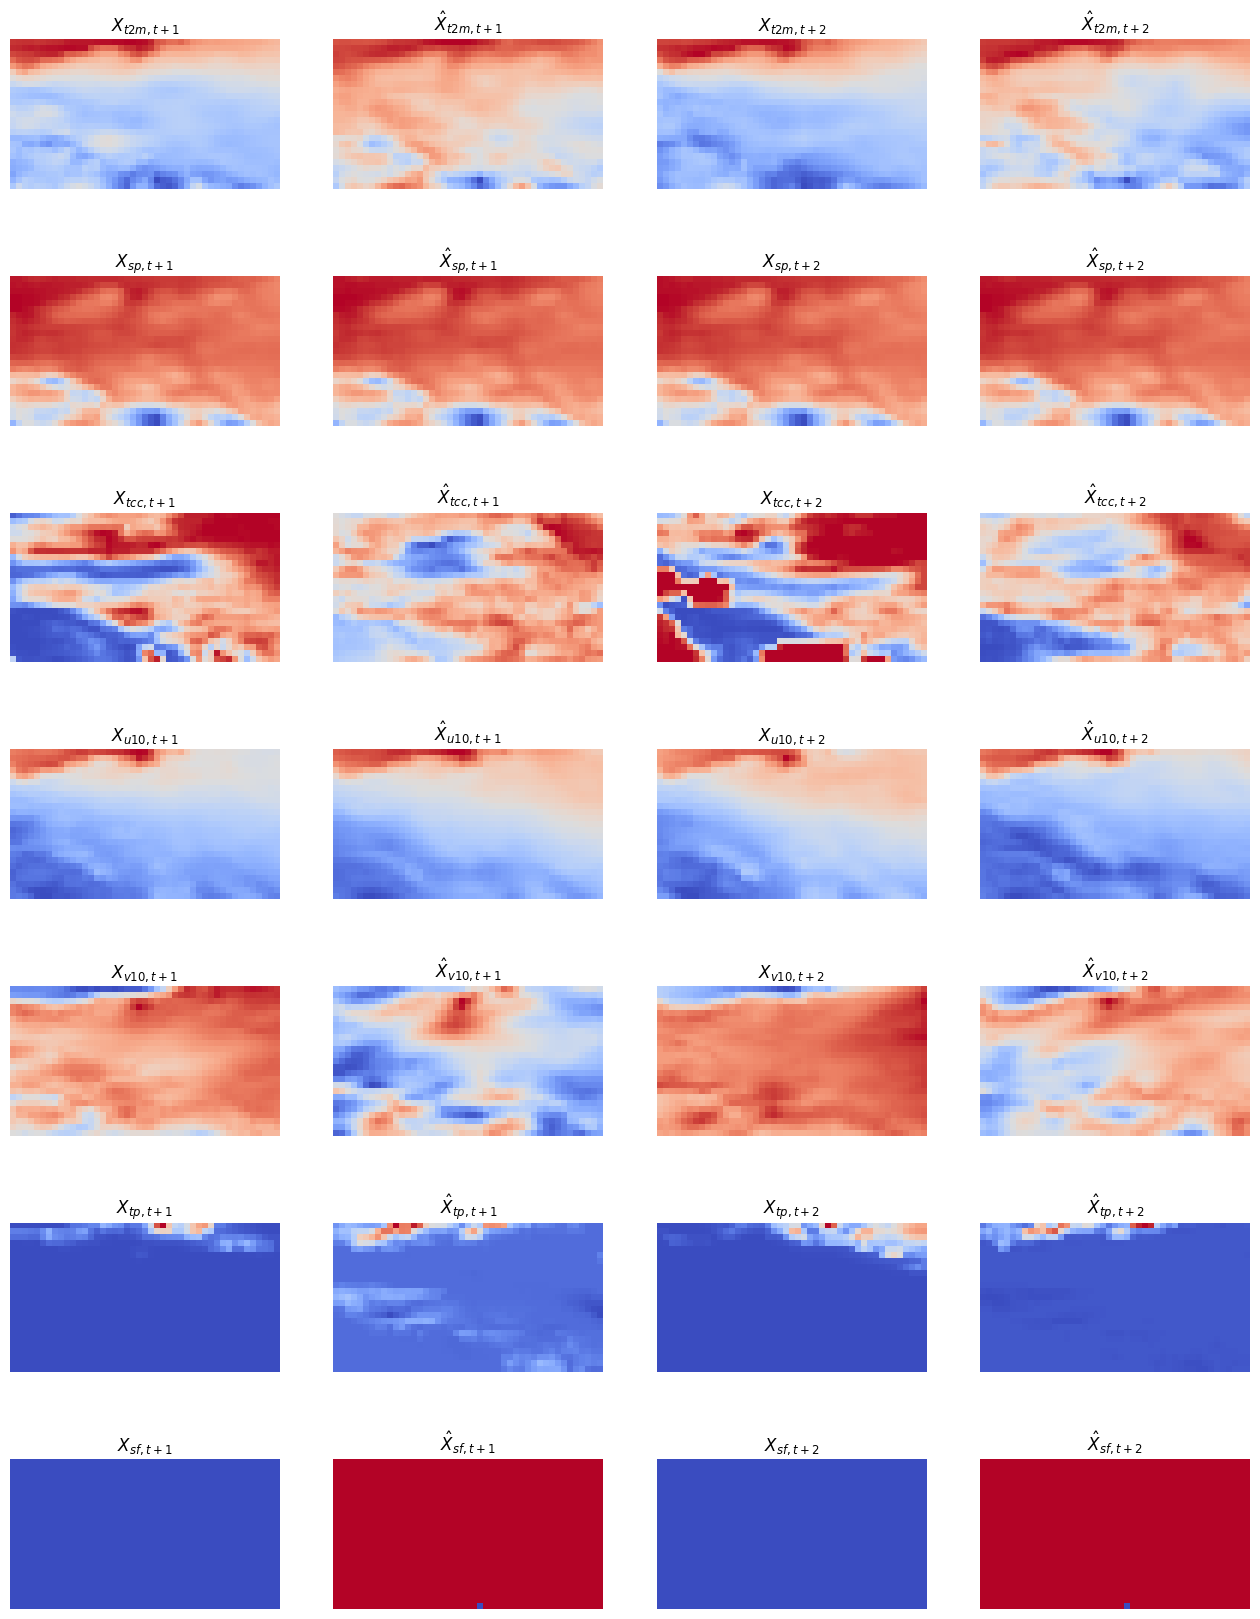

Evaluation metrics for entire test set:
RMSE t2m: 9.828858773957165; R2 t2m: -5745092.399902704
RMSE sp: 981.1047500150758; R2 sp: -13803420.705338638
RMSE tcc: 0.8937081918579823; R2 tcc: -8069172.084254399
RMSE u10: 3.7547300217642228; R2 u10: -1456120.5579100356
RMSE v10: 1.972567706936772; R2 v10: -1546501.7445413521
RMSE tp: 0.0005125870727286384; R2 tp: -1663876.3373903313
RMSE sf: 1.59106312078447e-06; R2 sf: -1696085.2088593268


In [7]:
reg = 'linear'
linearreg = Regressor(X.shape, fh, feature_list, regressor_type=reg)
linearreg.train(X_train, y_train)
y1,y2 = linearreg.predict_and_evaluate(X_test, y_test, max_samples=4)